# Face Blurring Technique in OpenCV

## 1. Load images

In [1]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
img1 = cv2.imread('child.jpg', cv2.IMREAD_COLOR)
img2 = cv2.imread('children.jpg', cv2.IMREAD_COLOR)

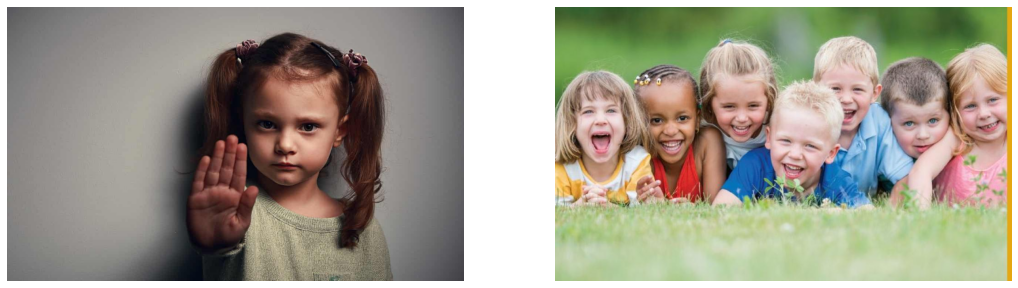

In [3]:
# Display the images
fig = plt.figure(figsize=(18,10))

plt.subplot(1,2,1); plt.axis('off'); plt.imshow(img1[:,:,::-1])
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(img2[:,:,::-1]);

## 2. Load the DNN Model

In [4]:
# Load DNN Caffe Model by reading the neural network weights and it's structure
modelFile = '../model/res10_300x300_ssd_iter_140000.caffemodel'
configFile = '../model/deploy.prototxt'

# Create a DNN object
net = cv2.dnn.readNetFromCaffe(prototxt = configFile, caffeModel=modelFile, )

## 3. Face Blurring

### 3.1 Define a blurring function

In [5]:
def blur(face, factor=3):
    h,w = face.shape[:2]
    
    if factor < 1:
        factor = 1 # Maximum blurring
    if factor > 5:
        factor = 5 # Minimum blurring
        
    # Kernel size
    w_k = int(w/factor)
    h_k = int(h/factor)
    
    # Make kernel an odd number
    if w_k%2 == 0:
        w_k +=1
    if h_k%2 == 0:
        h_k +=1
        
    blurred = cv2.GaussianBlur(face, (int(w_k), int(h_k)), 0, 0)
    
    return blurred

### 3.2 Face Detection and Blurring

#### 3.2.1 Rectangular Blurring

In [6]:
def face_blur_rect(image, net, factor=3, detection_threshold=0.9):
    img = image.copy()
    
    # Convert image to blob format
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=[104,117,123])
    
    # Pass the blob to the dnn model
    net.setInput(blob)
    
    # Get the detections from the DNN model
    detections = net.forward()
    
    (h,w) = img.shape[:2]
    
    # Process the detections
    for i in range(detections.shape[2]):
        confidence = detections[0,0,i,2]
        if confidence > detection_threshold:
            # Extract the bounding box from the detection
            box = detections[0,0,i,3:7] * np.array([w,h,w,h])
            (x1,y1,x2,y2) = box.astype('int')
            
            # Extract the face ROI
            face = img[y1:y2, x1:x2]
            
            # Blurring the face ROI
            face = blur(face, factor=factor)
            
            # Replace the detected face witht the blurred one
            img[y1:y2,x1:x2] = face
    return img

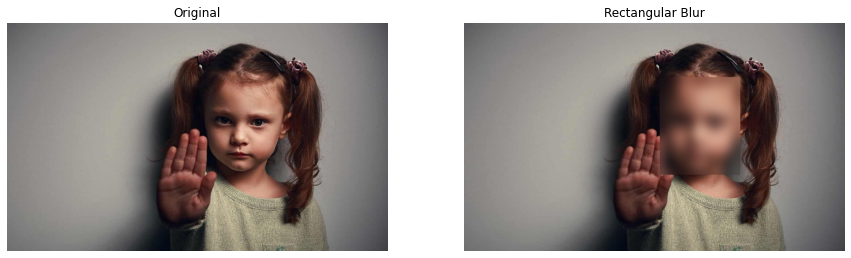

In [7]:
img1_rect = face_blur_rect(img1, net, factor=2.5)

fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1); plt.axis('off'); plt.imshow(img1[:,:,::-1]);      plt.title('Original')
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(img1_rect[:,:,::-1]); plt.title('Rectangular Blur');

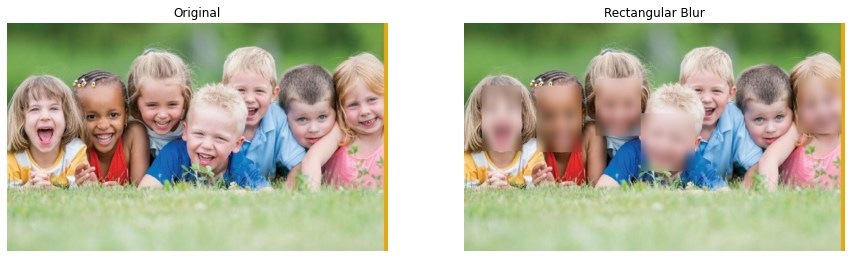

In [8]:
img2_rect = face_blur_rect(img2, net, factor=2)

fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1); plt.axis('off'); plt.imshow(img2[:,:,::-1]);      plt.title('Original')
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(img2_rect[:,:,::-1]); plt.title('Rectangular Blur');

#### 3.2.2 Elliptical Blurring

In [9]:
def face_blur_ellipse(image, net, factor=3, detect_threshold=0.90, write_mask=False):
    
    img = image.copy()
    img_blur = img.copy()
    
    elliptical_mask = np.zeros(img.shape, dtype=img.dtype)
    
    # Prepare image and perform inference.
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=[104, 117, 123])
    net.setInput(blob)
    detections = net.forward()
    
    h, w = img.shape[:2]
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > detect_threshold:

            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box

            # The face is defined by the bounding rectangle from the detection.
            face = img[int(y1):int(y2), int(x1):int(x2), :]
           
            # Blur the rectangular area defined by the bounding box.
            face = blur(face, factor=factor)

            # Copy the `blurred_face` to the blurred image.
            img_blur[int(y1):int(y2), int(x1):int(x2), :] = face
            
            # Specify the elliptical parameters directly from the bounding box coordinates.
            e_center = (x1 + (x2 - x1)/2, y1 + (y2 - y1)/2)
            e_size   = (x2 - x1, y2 - y1)
            e_angle  = 0.0
            
            # Create an elliptical mask. 
            elliptical_mask = cv2.ellipse(elliptical_mask, (e_center, e_size, e_angle), 
                                                      (255, 255, 255), -1, cv2.LINE_AA)  
            # Apply the elliptical mask
            np.putmask(img, elliptical_mask, img_blur)
            
    if write_mask:
        cv2.imwrite('elliptical_mask.jpg', elliptical_mask)

    return img

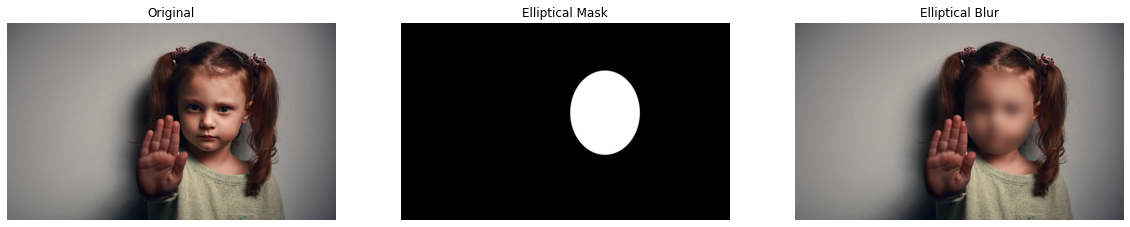

In [10]:
img1_ellipse = face_blur_ellipse(img1, net, factor=2.5, write_mask=True)

mask = cv2.imread('elliptical_mask.jpg')
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.axis('off'); plt.imshow(img1[:,:,::-1]);         plt.title('Original')
plt.subplot(1,3,2); plt.axis('off'); plt.imshow(mask);                   plt.title('Elliptical Mask')
plt.subplot(1,3,3); plt.axis('off'); plt.imshow(img1_ellipse[:,:,::-1]); plt.title('Elliptical Blur');

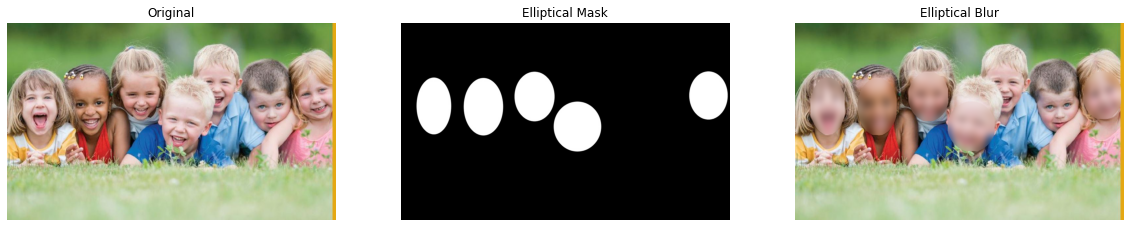

In [11]:
img2_ellipse = face_blur_ellipse(img2, net, factor=2, write_mask=True)

mask = cv2.imread('elliptical_mask.jpg')
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.axis('off'); plt.imshow(img2[:,:,::-1]);         plt.title('Original')
plt.subplot(1,3,2); plt.axis('off'); plt.imshow(mask);                   plt.title('Elliptical Mask')
plt.subplot(1,3,3); plt.axis('off'); plt.imshow(img2_ellipse[:,:,::-1]); plt.title('Elliptical Blur');

#### 3.2.3 Pixelated Blurring

In [12]:
# Define a pixelate function
def pixelate(roi, pixels=16):
    # Size of region to pixelate
    roi_h, roi_w = roi.shape[:2]
    
    if roi_h > pixels and roi_w > pixels:
        # Resize input ROI to the small pixelated size
        roi_small = cv2.resize(roi, (pixels, pixels), interpolation=cv2.INTER_LINEAR)
        
        # Now enlarge the pixelated ROI to fill the size of the original ROI
        roi_pixelated =cv2.resize(roi_small, (roi_w, roi_h), interpolation=cv2.INTER_NEAREST)
    else:
        roi_pixelated = roi
    
    return roi_pixelated

In [13]:
# Pixelated Blurring
def face_blur_pixelate(image, net, detection_threshold=0.9, pixels=10):
    img = image.copy()
    
    # Prepare image and perform inference
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=[104,117,123])
    net.setInput(blob)
    detections = net.forward()
    
    h,w = img.shape[:2]
    for i in range(detections.shape[2]):
        confidence = detections[0,0,i,2]
        if confidence > detection_threshold:
            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")
            
            face = img[y1:y2, x1:x2]
            face = pixelate(face, pixels=pixels)
            img[y1:y2, x1:x2] = face
            
    return img

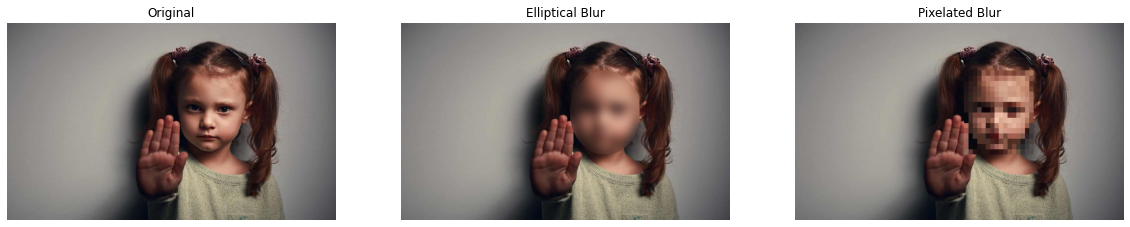

In [14]:
img1_pixel = face_blur_pixelate(img1, net, pixels=16)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.axis('off'); plt.imshow(img1[:,:,::-1]);         plt.title('Original')
plt.subplot(1,3,2); plt.axis('off'); plt.imshow(img1_ellipse[:,:,::-1]); plt.title('Elliptical Blur')
plt.subplot(1,3,3); plt.axis('off'); plt.imshow(img1_pixel[:,:,::-1]);   plt.title('Pixelated Blur');

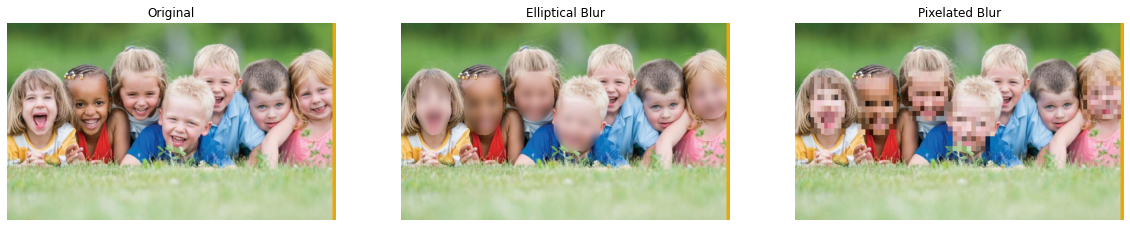

In [15]:
img2_pixel = face_blur_pixelate(img2, net, pixels=10)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.axis('off'); plt.imshow(img2[:,:,::-1]);         plt.title('Original')
plt.subplot(1,3,2); plt.axis('off'); plt.imshow(img2_ellipse[:,:,::-1]); plt.title('Elliptical Blur')
plt.subplot(1,3,3); plt.axis('off'); plt.imshow(img2_pixel[:,:,::-1]);   plt.title('Pixelated Blur');

#### 3.2.4 Combination Blurring: Elliptical and Pixelated

In [16]:
def face_blur_ellipse_pixelate(image, net, detect_threshold=0.9, factor=3, pixels=10, write_mask=False):
    
    img = image.copy()
    img_out = img.copy()
    elliptical_mask = np.zeros(img.shape, dtype=img.dtype)
    
    # Prepare image and perform inference.
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=[104, 117, 123])
    net.setInput(blob)
    detections = net.forward()
    
    h, w = img.shape[:2]
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > detect_threshold:

            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box

            # The face is defined by the bounding rectangle from the detection.
            face = img[int(y1):int(y2), int(x1):int(x2), :]
            
            # Blur the rectangular area defined by the bounding box.
            face = blur(face, factor=factor)
            
            # Pixelate the blurred face.
            face = pixelate(face, pixels=pixels)

            # Copy the blurred/pixelated face to the output image.
            img_out[int(y1):int(y2), int(x1):int(x2), :] = face
            
            # Specify the elliptical parameters directly from the bounding box coordinates.
            e_center = (x1 + (x2 - x1)/2, y1 + (y2 - y1)/2)
            e_size   = (x2 - x1, y2 - y1)
            e_angle  = 0.0
            
            # Create an elliptical mask. 
            elliptical_mask = cv2.ellipse(elliptical_mask, (e_center, e_size, e_angle), 
                                                      (255, 255, 255), -1, cv2.LINE_AA)
            # Apply the elliptical mask.
            np.putmask(img, elliptical_mask, img_out)
            
    if write_mask:
        cv2.imwrite('elliptical_mask.jpg', elliptical_mask)
        
    return img

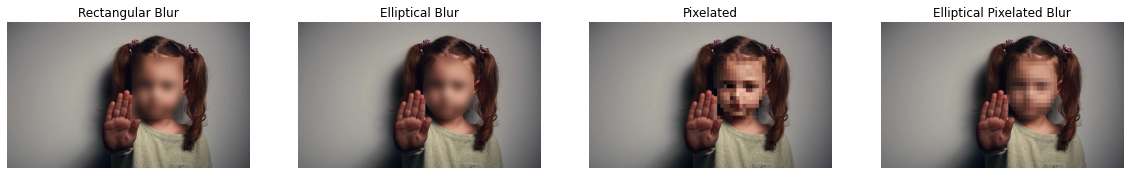

In [17]:
img1_epb = face_blur_ellipse_pixelate(img1, net, factor=3.5, pixels=15)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,4,1); plt.axis('off'); plt.imshow(img1_rect[:,:,::-1]);    plt.title('Rectangular Blur')
plt.subplot(1,4,2); plt.axis('off'); plt.imshow(img1_ellipse[:,:,::-1]); plt.title('Elliptical Blur')
plt.subplot(1,4,3); plt.axis('off'); plt.imshow(img1_pixel[:,:,::-1]);   plt.title('Pixelated')
plt.subplot(1,4,4); plt.axis('off'); plt.imshow(img1_epb[:,:,::-1]);     plt.title('Elliptical Pixelated Blur');

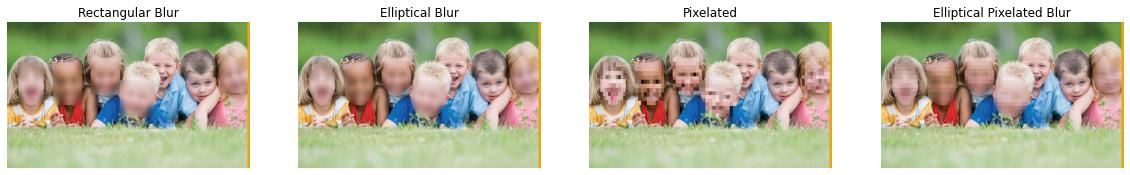

In [18]:
img2_epb = face_blur_ellipse_pixelate(img2, net, factor=2, pixels=10)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,4,1); plt.axis('off'); plt.imshow(img2_rect[:,:,::-1]);    plt.title('Rectangular Blur')
plt.subplot(1,4,2); plt.axis('off'); plt.imshow(img2_ellipse[:,:,::-1]); plt.title('Elliptical Blur')
plt.subplot(1,4,3); plt.axis('off'); plt.imshow(img2_pixel[:,:,::-1]);   plt.title('Pixelated')
plt.subplot(1,4,4); plt.axis('off'); plt.imshow(img2_epb[:,:,::-1]);     plt.title('Elliptical Pixelated Blur');